In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2


def load_and_preprocess(folder_path):
  # Iterate through all the images in the folder
  for filename in os.listdir(folder_path):
      if filename.endswith(".png"):
          # Load the X-ray image
          image = Image.open(os.path.join(folder_path, filename))

          # Noise Reduction: Gaussian Blur
          blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

          # Edge Detection: Canny Edge Detector
          edges = cv2.Canny(blurred_image, 50, 150)

          # Find contours
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          # Draw contours on a blank image
          contour_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
          cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

          roi = contour_img[14:255 , 20:282]

          return roi

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_path = "/content/drive/MyDrive/Train_withoutMask"
test_path = "/content/drive/MyDrive/Test_withoutMask"

batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=load_and_preprocess(train_path)
)

test_datagen = ImageDataGenerator(preprocessing_function=load_and_preprocess(test_path))

# Train/validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',

)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)


In [ ]:
# Import Resnet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Create a Sequential model
model = Sequential()


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.add(base_model)

# Add GlobalAveragePooling2D layer to reduce dimensions
model.add(GlobalAveragePooling2D())

# Dense layer for binary classification with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and appropriate metrics
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
H = model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1, callbacks=[es])


Epoch 1/10
50/50 [==============================] - 433s 9s/step - loss: 0.5650 - accuracy: 0.7212 - val_loss: 0.4565 - val_accuracy: 0.8275
Epoch 2/10
50/50 [==============================] - 434s 9s/step - loss: 0.3579 - accuracy: 0.9031 - val_loss: 0.3262 - val_accuracy: 0.8975
Epoch 3/10
50/50 [==============================] - 489s 10s/step - loss: 0.2561 - accuracy: 0.9344 - val_loss: 0.2796 - val_accuracy: 0.9325
Epoch 4/10
50/50 [==============================] - 487s 10s/step - loss: 0.2131 - accuracy: 0.9488 - val_loss: 0.2397 - val_accuracy: 0.9250
Epoch 4: early stopping


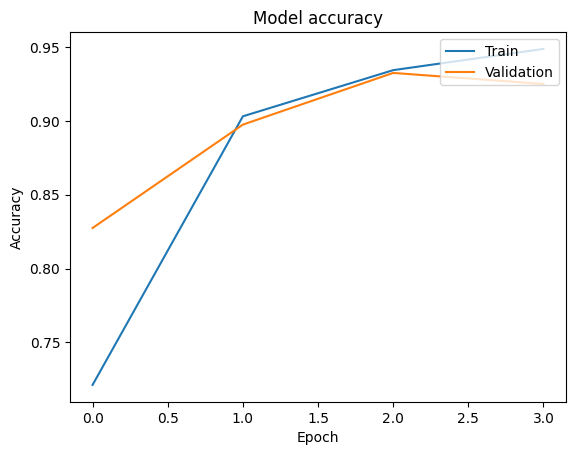

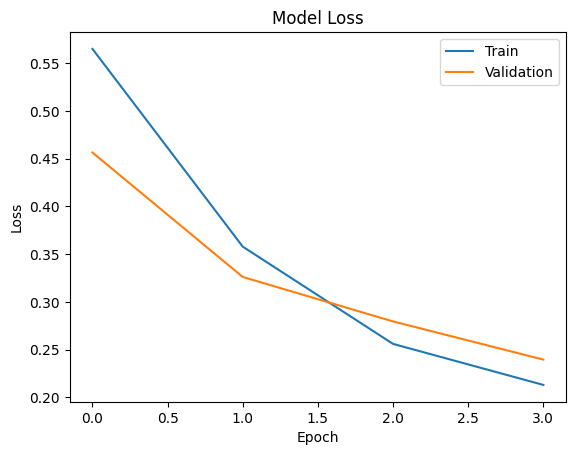

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
drive_path = '/content/drive/My Drive/'
model.save(drive_path+'ROI_Resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_binary)
class_report = classification_report(y_true, y_pred_binary)
print("Classification Report:\n", class_report)

7/7 [==============================] - 63s 9s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.53      0.51       100
           1       0.50      0.47      0.48       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200



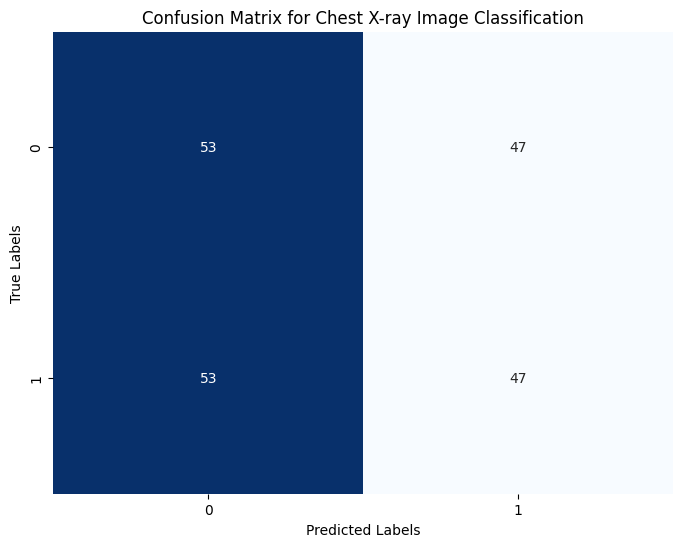

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Chest X-ray Image Classification')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/ROI_without_tuning/ROI_Resnet50.h5")

In [ ]:
import pickle
# Extract model weights and architecture
model_weights = model.get_weights()
model_config =model.get_config()

# Save weights and config as a .pkl file
with open('Resnet50v2_model1.pkl', 'wb') as f:
    pickle.dump([model_weights, model_config], f)

EXTRA WORK

In [ ]:
import pickle

with open('ROI_Resnet50.pkl', 'wb') as file:
  pickle.dump(model, file)

PICKLE FILE

In [ ]:
import bz2
import pickle
import tensorflow as tf
drive_path = '/content/drive/My Drive/'

# Load the model from the .h5 file
model = tf.keras.models.load_model(drive_path +'ROI_without_tuning/ROI_Resnet50.h5')

# Extract model weights and architecture
model_weights = model.get_weights()
model_config = model.get_config()

# Save weights and config as a .pkl file
with open('Resnet50_roi.pkl', 'wb') as f:
    pickle.dump([model_weights, model_config], f)

In [ ]:
# Define the path where you want to save the model in Google Drive
drive_path = '/content/drive/My Drive/'

import joblib
from tensorflow.keras.models import load_model

# Load the .h5 model
model_h5 = load_model(drive_path+'ROI_without_tuning/ROI_Resnet50.h5')

# Convert the model to byte stream using joblib
with open('Resnet50_roi.pkl', 'wb') as file:
    joblib.dump(model_h5, file)